# Analyis of Turbulence Data

In [197]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy import signal
from lmfit import Model
# https://lmfit.github.io/lmfit-py/builtin_models.html
# https://cars9.uchicago.edu/software/python/lmfit/builtin_models.html

import lmfit
label_size = 18
plt.rcParams.update(
    {
        "font.size": label_size,
        "legend.title_fontsize": label_size,
        "legend.fontsize": label_size,
        "axes.labelsize": label_size,
        "xtick.labelsize": label_size,
        "ytick.labelsize": label_size,
        "axes.labelpad": 4,
        # "lines.markersize": 13,
        "lines.linewidth": 2,
    }
)

Exercise 5

In [31]:
data = np.loadtxt('Data/k10mf_processed_FD2.txt')

5.1) Calculate mean $u_{mean}  = \langle u \rangle$ and standard deviation $u_{std} = \sqrt{\langle u^2 \rangle - (\langle u \rangle)^2}$

In [32]:
# Sample frequency 20 kHz
f_s = 20_000
T = len(data)/f_s
print(f'The dataset is is {T}s long.')

# Mean and standard deviation
u_mean = np.mean(data)
u_std = np.std(data)

The dataset is is 62.88915s long.


The mean velocity is 6.39m/s.
The standard deviation is +/- 0.16m/s.


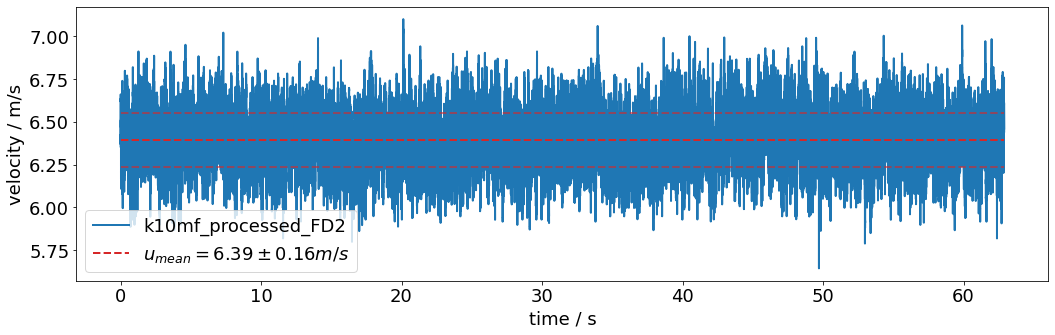

In [33]:
fig, ax = plt.subplots(figsize=(15,5), tight_layout=True)
time = np.linspace(0,T,len(data))
ax.plot(time, data, label='k10mf_processed_FD2', zorder=1)

# Plot time series and mean +/- std velocity
print(f'The mean velocity is {u_mean:.2f}m/s.\nThe standard deviation is +/- {u_std:.2f}m/s.')
ax.hlines(u_mean, 0, T, colors='C3', linestyles='--', zorder=2, label=f'$u_{{mean}}={{{u_mean:.2f}}} \pm {{{u_std:.2f}}} m/s$')
ax.hlines(u_mean+u_std, 0, T, colors='C3', linestyles='--', zorder=2, alpha=0.6)
ax.hlines(u_mean-u_std, 0, T, colors='C3', linestyles='--', zorder=2, alpha=0.6)

ax.set_xlabel('time / s')
ax.set_ylabel('velocity / m/s')
ax.legend()
fig.savefig('Abb/Velocity_Time_Series.png')

### 5.2) Use Taylor's hypothesis $x = u_{mean} \cdot t$ to calculate a spatial series from a temporal series
Essentially, you assume that the velocity field you record at one spatial position over time only gets advected but not deformed by the mean velocity.

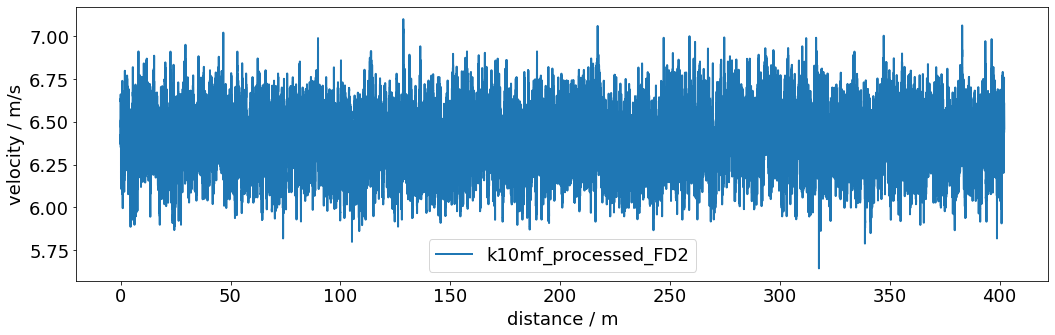

In [35]:
fig, ax = plt.subplots(figsize=(15,5), tight_layout=True)
spatial = time * u_mean
ax.plot(spatial, data, label='k10mf_processed_FD2', zorder=1)
ax.set_xlabel('distance r / m')
ax.set_ylabel('velocity / m/s')
ax.legend()
fig.savefig('Abb/Velocity_Spatial_Series.png')

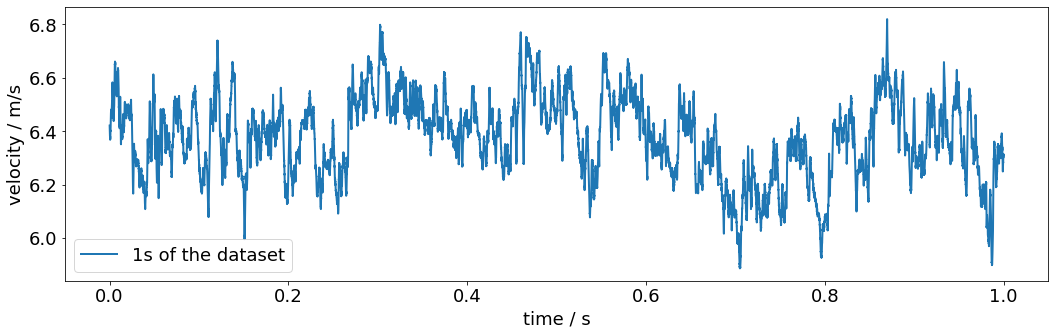

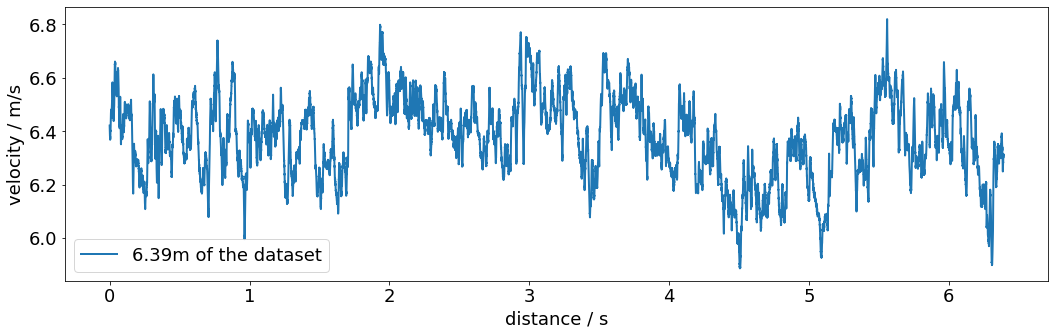

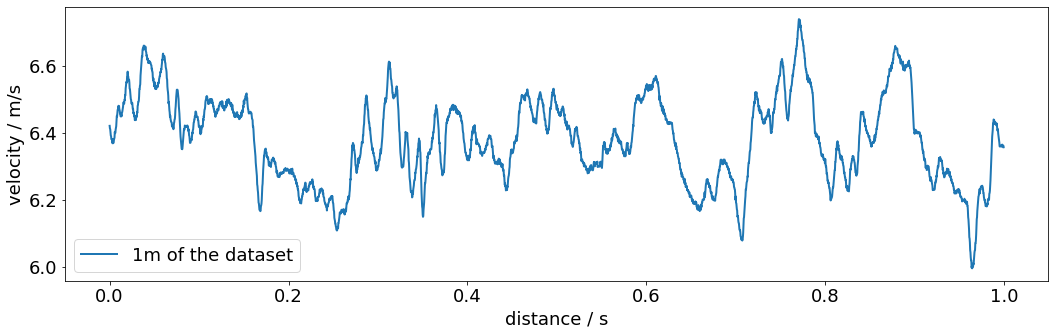

In [36]:
fig, ax = plt.subplots(figsize=(15,5), tight_layout=True)
ax.plot(time[:f_s], data[:f_s], label='1s of the dataset', zorder=1)
ax.set_xlabel('time / s')
ax.set_ylabel('velocity / m/s')
ax.legend()

fig, ax = plt.subplots(figsize=(15,5), tight_layout=True)
ax.plot(spatial[:f_s], data[:f_s], label=f'{u_mean:.2f}m of the dataset', zorder=1)
ax.set_xlabel('distance r / m')
ax.set_ylabel('velocity / m/s')
ax.legend()

fig, ax = plt.subplots(figsize=(15,5), tight_layout=True)
ax.plot(spatial[:int(f_s/u_mean)], data[:int(f_s/u_mean)], label='1m of the dataset', zorder=1)
ax.set_xlabel('distance r / m')
ax.set_ylabel('velocity / m/s')
ax.legend()

5.3) Calculate correlation function $C(r) = \langle u'(x+r)u'(x) \rangle$ of the fluctuations $u' = u - \langle u \rangle$

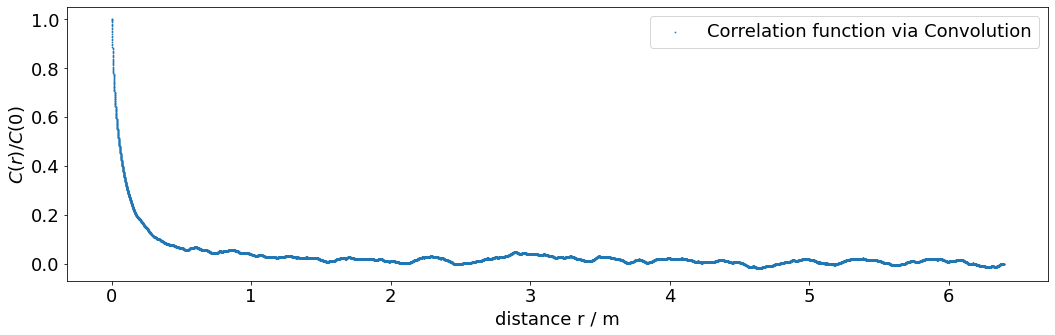

In [356]:
# Number of seconds in the dataset to do the computation
sec = 1
data_fluc = data - u_mean

fig, ax = plt.subplots(figsize=(15,5), tight_layout=True)
# Not exactly the same one
# acf = sm.tsa.acf(data_fluc, nlags=f_s*sec, fft=True)
# ax.plot(spatial[:f_s*sec+1], acf, label='Autocorrelation function', zorder=1)


# Correlation via convolution: Much faster than doing it for each r by my own
# 2s for all r instead of 4 Minutes for only 20.000 r
cf_cov = signal.fftconvolve(data_fluc, data_fluc[::-1], mode='full')
# Devide by how many samples were involved in convolution
xi = np.arange(1, len(data_fluc) + 1)
d = np.hstack((xi, xi[:-1][::-1]))
cf_cov = cf_cov / d

# Only the first half is our correlation
cf_cov = cf_cov[:len(data_fluc)][::-1]
cf_cov_0 = cf_cov[0]
cf_cov = cf_cov/cf_cov[0]
ax.scatter(spatial[:f_s*sec+1], cf_cov[:f_s*sec+1], label='Correlation function via Convolution', zorder=1, s=0.5)

ax.set_xlabel('distance r / m')
ax.set_ylabel('$C(r)/C(0)$')
ax.legend()
fig.savefig('Abb/Correlation.png')

5.4) Determine integral length scale $L=\int_0^{\infty} dr \frac{C(r)}{C(0)}$ and by an exponential fit $C(r) \approx C(0) \cdot e^{-\frac{r}{L}}$

Integral length via summation: L = 0.0259m
Integral length via fit: L = 0.3376m


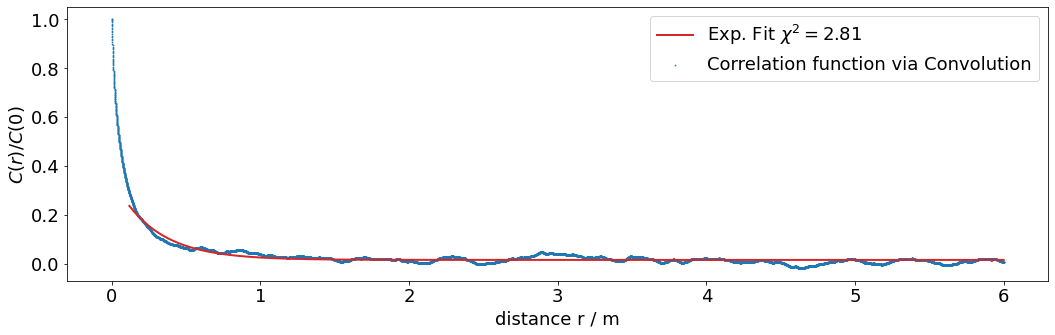

In [370]:
fig, ax = plt.subplots(figsize=(15,5), tight_layout=True)

# 1) Integral length scale via Integral = Summation of rectangles
step = time[1]-time[0]

# Zero crossing zc
zc = np.argwhere(cf_cov < 0)[0,0]
L_sum = np.sum(cf_cov[:zc])*step
print(f'Integral length via summation: L = {L_sum:.4f}m')

# 2) Integral length scale via exp-fit
# begin, end of fit in m
begin, end = 0.12, 6
idx_b, idx_e = int(begin/u_mean*f_s) , int(end/u_mean*f_s) 

xdat = spatial[idx_b:idx_e]
ydat = cf_cov[idx_b:idx_e]

mod = lmfit.models.ExponentialModel() + lmfit.models.ConstantModel()
# pars = mod.make_params()
result = mod.fit(ydat, x=xdat)
L_fit = result.values['amplitude']
print(f'Integral length via fit: L = {L_fit:.4f}m')

# print(result.fit_report())
plt.plot(xdat, result.eval(result.params, x=xdat), c='C3', label=f'Exp. Fit $\chi^2={{{result.chisqr:.2f}}}$')
ax.scatter(spatial[:idx_e], cf_cov[:idx_e], label='Correlation function via Convolution', zorder=1, s=0.5)

ax.set_xlabel('distance r / m')
ax.set_ylabel('$C(r)/C(0)$')
ax.legend()
fig.savefig('Abb/Correlation_Zoomed_Fit.png')

Try out different begin and end points for the fit

In [295]:
size = 30
L_matrix = np.empty((size,size)) 
b_vec = np.linspace(0.1,0.5,size)
e_vec = np.linspace(3,10,size)
for i, begin in enumerate(b_vec):
    for j, end in enumerate(e_vec):
        idx_b, idx_e = int(begin/u_mean*f_s) , int(end/u_mean*f_s) 
        xdat = spatial[idx_b:idx_e]
        ydat = cf_cov[idx_b:idx_e]

        mod = lmfit.models.ExponentialModel() + lmfit.models.ConstantModel()
        try:
            result = mod.fit(ydat, x=xdat)
            L = result.values['amplitude']
        except:
            L = None
        L_matrix[i,j] = L

The value of L really depends on the start and end point of our fit!

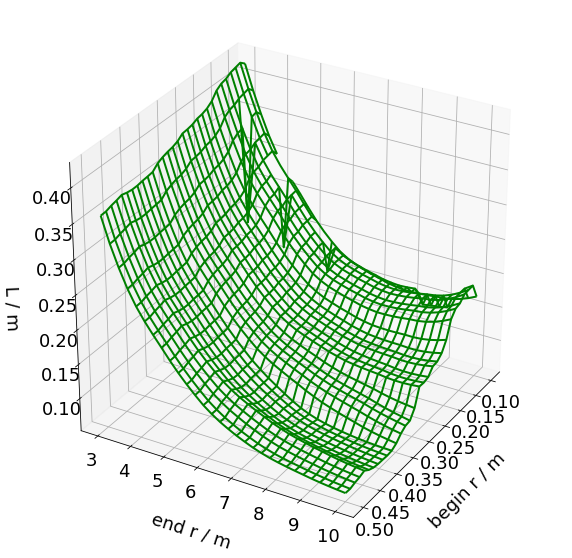

In [304]:
fig, ax = plt.subplots(figsize=(10,10))
ax = plt.axes(projection ='3d')
X, Y = np.meshgrid(b_vec, e_vec)
# ax.plot3D(b_vec[:len(L_matrix)], e_vec[:len(L_matrix)], L_matrix)
ax.plot_wireframe(X, Y, L_matrix, color ='green')
ax.set_xlabel('begin r / m')
ax.set_ylabel('end r / m')
ax.set_zlabel('L / m')
ax.view_init(30, 30)
ax.yaxis.labelpad = 20
ax.xaxis.labelpad = 20
ax.zaxis.labelpad = 20
fig.savefig('Abb/Different_integral_lengths_L.png')


5.5) Determine Taylor length $\lambda = \sqrt{-\frac{C(0)}{C^{''}(0)}}$

Taylor length lambda via cf_cov[0] = 0.0026m
[[Model]]
    Model(parabolic)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 7
    # variables        = 3
    chi-square         = 5.5260e-08
    reduced chi-square = 1.3815e-08
    Akaike info crit   = -124.599882
    Bayesian info crit = -124.762151
[[Variables]]
    a: -3738.93693 +/- 125.543927 (3.36%) (init = 0)
    b: -2.12421281 +/- 0.25058120 (11.80%) (init = 0)
    c:  0.99990890 +/- 1.0259e-04 (0.01%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -0.961
    C(b, c) = -0.781
    C(a, c) = 0.625


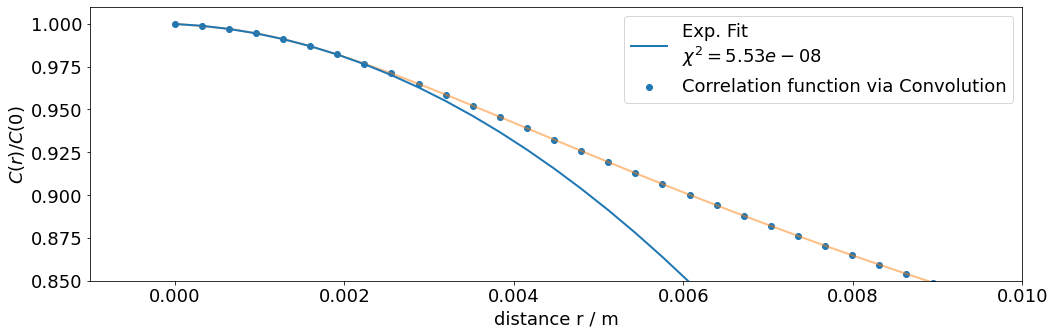

In [358]:
fig, ax = plt.subplots(figsize=(15,5), tight_layout=True)

# Taylor length scale via polynomial fit
# begin, end of fit in m
dpoints = 50
idx_b, idx_e = 0, 7

xdat = spatial[idx_b:idx_e]
ydat = cf_cov[idx_b:idx_e]

mod = lmfit.models.QuadraticModel()
result = mod.fit(ydat, x=xdat)
C_curvature = result.values['a']
# print(f'Taylor length lambda via cf_cov[0]= 1 normed = {np.sqrt(-cf_cov[0]/C_curvature):.4f}m')
print(f'Taylor length lambda via cf_cov[0] = {np.sqrt(-cf_cov_0/C_curvature):.4f}m')



ax.plot(spatial[:dpoints], result.eval(result.params, x=spatial[:dpoints]), label=f'Exp. Fit\n$\chi^2={{{result.chisqr:.2e}}}$')
ax.scatter(spatial[:dpoints], cf_cov[:dpoints], label='Correlation function via Convolution', zorder=1)
ax.plot(spatial[:dpoints], cf_cov[:dpoints], alpha=0.5, zorder=1)

ax.set_xlim((-0.001,0.01))
ax.set_ylim((0.85,1.01))
ax.set_xlabel('distance r / m')
ax.set_ylabel('$C(r)/C(0)$')
ax.legend()
fig.savefig('Abb/Correlation_Taylor_length.png')

print(result.fit_report())

Try out different end point of the correlation function and look at Chi-Square for best fit

Minimum chi-sqr (best number of indices) at index e_idx = 3


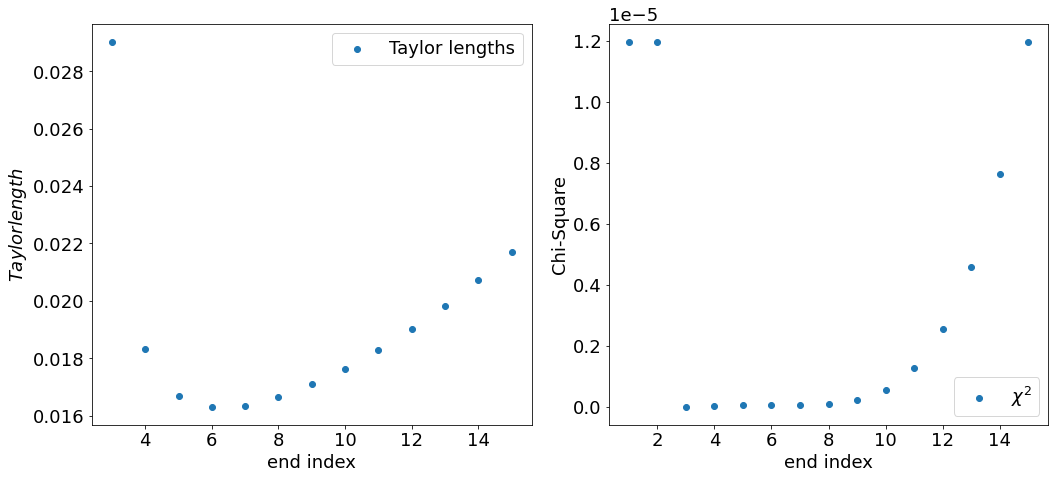

In [352]:
num_idx = 15
taylor_lengths = np.empty(num_idx)
chi_sqr = np.empty(num_idx)

indices = np.linspace(1,num_idx,num_idx)

for idx_e in indices:
    idx_e = int(idx_e)
    xdat = spatial[:idx_e]
    ydat = cf_cov[:idx_e]

    mod = lmfit.models.QuadraticModel()
    try: 
        result = mod.fit(ydat, x=xdat)
        C_curvature = result.values['a']
        lambda_l = np.sqrt(-cf_cov[0]/C_curvature)
    except:
        lambda_l = None
    taylor_lengths[idx_e-1] = lambda_l
    chi_sqr[idx_e-1] = result.chisqr


fig, ax = plt.subplots(1,2,figsize=(15,7), tight_layout=True)

ax[0].scatter(indices, taylor_lengths, label='Taylor lengths', zorder=1)
ax[0].set_xlabel('end index')
ax[0].set_ylabel('$Taylor length$')

ax[1].scatter(indices, chi_sqr, label='$\chi^2$', zorder=1)
ax[1].set_xlabel('end index')
ax[1].set_ylabel('Chi-Square')


ax[0].legend()
ax[1].legend()
print(f'Minimum chi-sqr (best number of indices) at index e_idx = {np.argmin(chi_sqr)+1}')

fig.savefig('Abb/Correlation_Taylor_length_different_idx.png')


5.6) Calculate Structure Function $S_n(r) = \langle[u(x+r) - u(x)]^n \rangle$

In [361]:
R_struc = np.logspace(0.6, 3.5, 50, dtype='int')
struc = np.zeros((7,np.size(R_struc)))
for nn in range(1,7):
    for rr in range(np.size(R_struc)):
        struc[nn,rr] = np.mean((data[:-R_struc[rr]]-data[R_struc[rr]:])**nn)

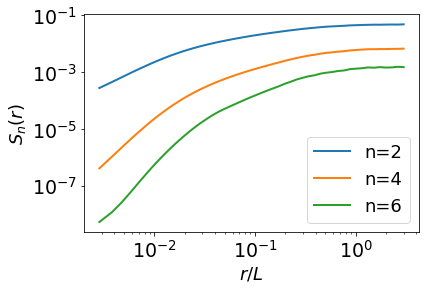

In [372]:
# even structure functions
dr = u_mean/f_s
plt.plot(R_struc*dr/L_fit,struc[2], label='n=2')
plt.plot(R_struc*dr/L_fit,struc[4], label='n=4')
plt.plot(R_struc*dr/L_fit,struc[6], label='n=6')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$r/L$', fontsize=18)
plt.ylabel('$S_n(r)$', fontsize=18)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.legend()
plt.savefig('even_struc.pdf', bbox_inches='tight')

In [417]:
r_in_log = np.logspace(0.5, 3, 50, dtype='int')
struct = np.empty((7,np.size(r_in_log)))

for n in range(1,7):
    for r in range(np.size(r_in_log)):
        struc[n,r] = np.mean((data[:-r_in_log[r]]-data[r_in_log[r]:])**n)

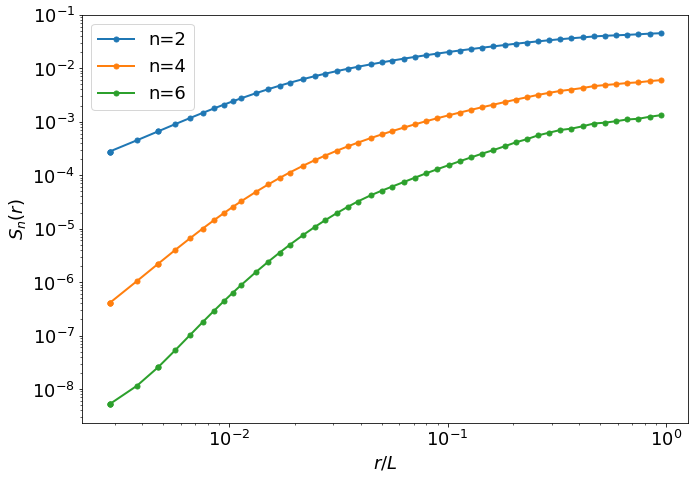

In [418]:
# Even structure functions
fig, ax = plt.subplots(figsize=(10,7), tight_layout=True)

dr = u_mean/f_s
ax.loglog(r_in_log*dr/L_fit,struc[2], label='n=2', marker='.', ms=10)
ax.loglog(r_in_log*dr/L_fit,struc[4], label='n=4', marker='.', ms=10)
ax.loglog(r_in_log*dr/L_fit,struc[6], label='n=6', marker='.', ms=10)

ax.set_xlabel('$r/L$')
ax.set_ylabel('$S_n(r)$')
ax.legend()
plt.savefig('Abb/Even_structure_functions')

A power-law like $r^{\zeta_n}$ should look like a linear graph with slope $\zeta_n$  
When r is large (approximately L) then we have Gaussian fluctuations and the model isn't that good anymore

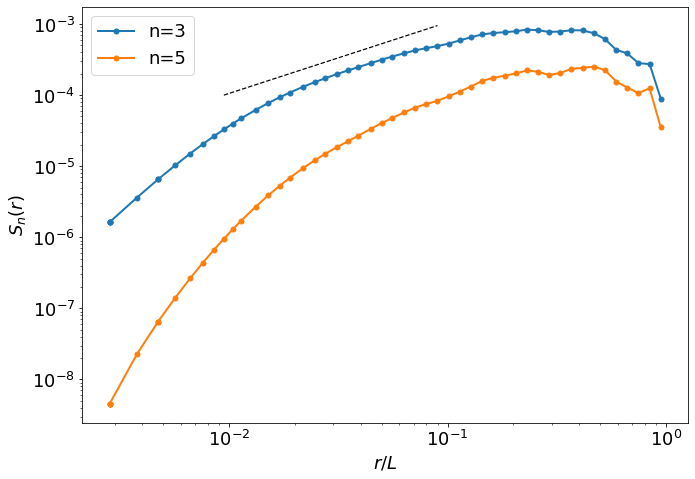

In [434]:
# Odd structure functions
fig, ax = plt.subplots(figsize=(10,7), tight_layout=True)

ax.loglog(r_in_log*dr/L_fit,-struc[3], label='n=3', marker='.', ms=10)
ax.loglog(r_in_log*dr/L_fit,-struc[5], label='n=5', marker='.', ms=10)

ax.plot(r_in_log[10:30]*dr/L_fit, r_in_log[10:30]*10**(-5), linestyle='dashed', color='black', lw=1.2)

ax.set_xlabel('$r/L$')
ax.set_ylabel('$S_n(r)$')
ax.legend()
plt.savefig('Abb/Odd_structure_functions')

A power-law like $r^{\zeta_n}$ should look like a linear graph with slope $\zeta_n$. Here for example $\zeta_n = 2$

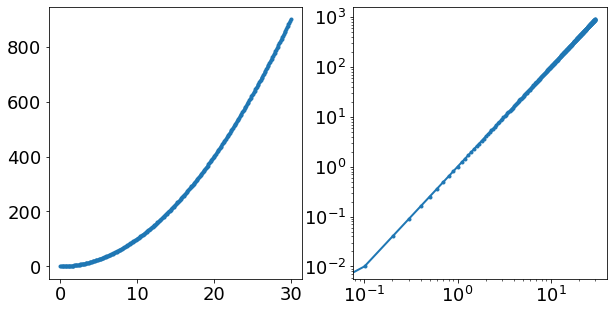

In [448]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
r_lin = np.linspace(0,30,300)
y = np.power(r_lin,2)
ax[0].plot(r_lin,y, marker='.')
ax[1].loglog(r_lin, y, marker='.')

# Exercise 6/7